In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from astropy import units as u
from hugs.datasets import CatButler
from hugs.datasets.hugged import merge_synth_cats
import hugs_pipe as hp
from toolbox.cosmo import Cosmology
cosmo = Cosmology()
plt.style.use('jpg')

In [2]:
def remove_duplicates(cat, min_sep=0.7):
    """
    Build mask for double entries in a catalog. 
    Consider object within min_sep arcsec the same object
    """
    from toolbox.astro import angsep
    mask = np.ones(len(cat), dtype=bool)
    cat.reset_index(drop=True, inplace=True)
    counts = []
    for i, (ra, dec) in enumerate(cat[['ra','dec']].values):
        # don't search objects flagged as double entries
        if mask[i]==True:
            seps = angsep(ra, dec, cat['ra'], cat['dec'])
            unique = seps > min_sep
            unique[i] = True # it will certainly match itself
            mask &= unique   # double entries set to False
            counts.append(cat.loc[~unique, group_ids].sum(axis=0).values)
        else:
            counts.append(np.zeros(len(group_ids)))
    counts = pd.DataFrame(columns=group_ids, data=counts, dtype=int)
    cat.loc[:, group_ids] = cat.loc[:, group_ids].copy() + counts
    cat.drop(cat.index[~mask], inplace=True)

In [3]:
cb = CatButler()
groups = cb.combine_group_cats()
groups = pd.merge(groups, cb.group_props, on='group_id', suffixes=['', '_group'])
groups['D_A'] = cosmo.D_A(groups['z'])
for band in 'gri':
    groups['r_kpc('+band+')'] = u.arcsec.to('radian')*groups['r_e('+band+')']*groups['D_A']*1e3
groups['g-i'] = groups['m_tot(g)'] - groups['m_tot(i)']
groups['g-r'] = groups['m_tot(g)'] - groups['m_tot(r)']
for i in range(8):
    groups['g-i_aper_'+str(i)] = groups['MAG_APER_'+str(i)+'(g)'] - groups['MAG_APER_'+str(i)+'(i)']
groups.dropna(inplace=True)
groups.reset_index(drop=True, inplace=True)
rows = np.zeros((len(groups), len(groups['group_id'].unique())), dtype=int)
ids = pd.DataFrame(columns=groups['group_id'].unique().astype(str), data=rows)
for i in range(len(groups)):
    row = (groups.loc[i, 'group_id']==groups['group_id'].unique()).astype(int)
    ids.iloc[i] = row
groups = pd.concat([groups, ids], axis=1)
group_ids = groups['group_id'].unique().astype(str)

In [4]:
cut = groups['mu_0(g)'] > 23.5
cut &= groups['r_e(g)'] < 30
cut &= groups['r_kpc(g)'] > 1.8
cut &= np.abs(groups['dmu(i)']) < 1.
cut &= np.abs(groups['dmu(g)']) < 1.
cut &= np.abs(groups['dR0']) < 15
cut &= groups['n'] > 0.01
sample = groups[cut].copy()
sample.reset_index(inplace=True, drop=True)

In [5]:
remove_duplicates(sample)
len(sample)

698

In [6]:
sample.to_csv('/Users/protostar/Desktop/sample.csv', index=False)

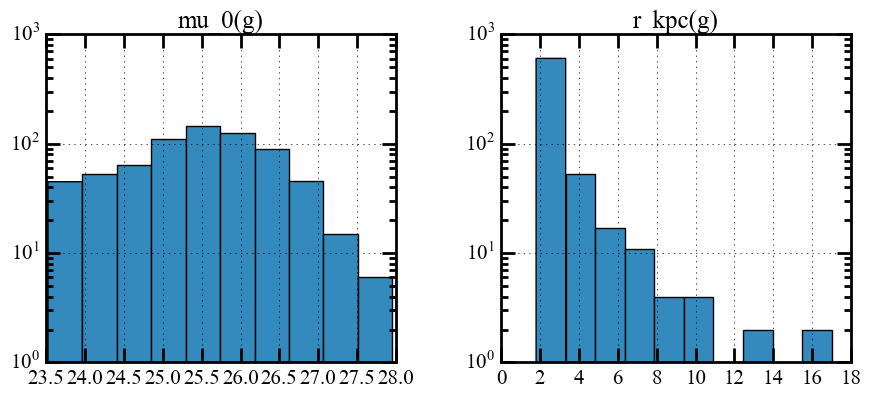

In [7]:
sample.hist(['mu_0(g)', 'r_kpc(g)'], figsize=(10,4), log=True);

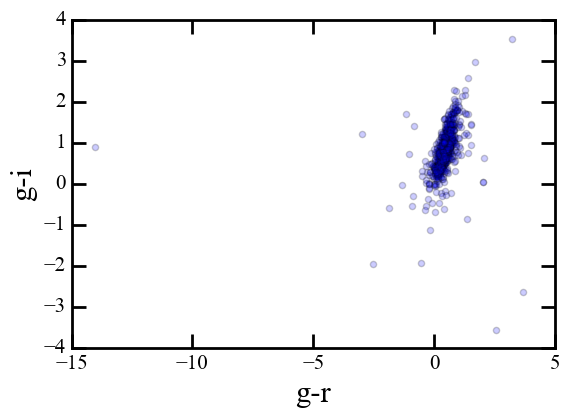

In [9]:
sample.plot.scatter('g-r', 'g-i', alpha=0.2);

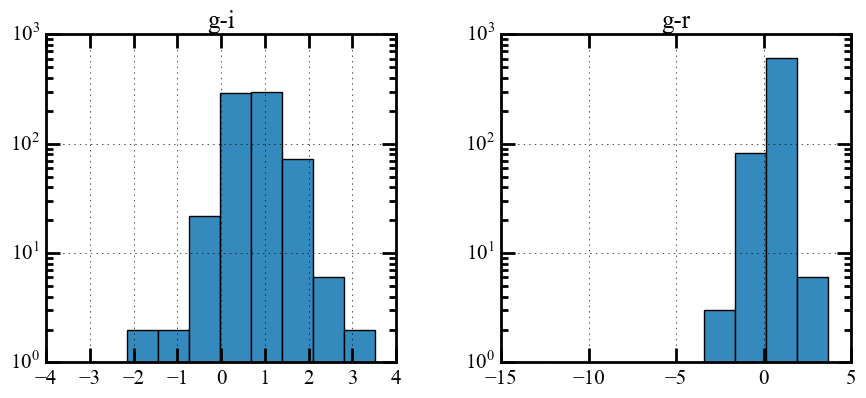

In [10]:
sample.hist(['g-r', 'g-i'], log=True, figsize=(10,4));

In [11]:
fwhm = 25*0.168
zmin, zmax = cb.group_props['z'].min(), cb.group_props['z'].max()
fwhm*u.arcsec.to('radian')*cosmo.D_A([zmin, zmax])*1e3 # kpc

array([ 1.486954  ,  4.14870897])